In [1]:
import pandas as pd
import numpy as np
import re
import os
import pymysql
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from IPython.display import display_html
from multiprocessing import Pool

%matplotlib inline
pd.set_option('display.max_columns', 50)

In [2]:
# This function allows displaying of multiple data frames next to eachother. 
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

In [3]:
cred = os.environ.get('SQL')
engine = create_engine('mysql+pymysql://'+cred+'@localhost/books_project')

In [4]:
bx_books = pd.read_sql("bx_books", con=engine).drop("index", axis=1)
bx_book_r = pd.read_sql("bx_book_r", con=engine).drop("index", axis=1)
amazon32 = pd.read_sql("amazon32", con=engine).drop("index", axis=1)
gr_books_10k = pd.read_sql("gr_books_10k", con=engine).drop("index", axis=1)
gr_books_k = pd.read_sql("gr_books_k", con=engine)

In [5]:
# Remove 0 ratings as these are not actual ratings. They amount to about 1/3 of the dataset. 
bx_book_r = bx_book_r[bx_book_r["Book-Rating"]!=0]
bx_book_r

,User-ID,ISBN,Book-Rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6
...,...,...,...
1149773,276704,0806917695,5
1149775,276704,1563526298,9
1149777,276709,0515107662,10
1149778,276721,0590442449,10


Count ratings for each rating

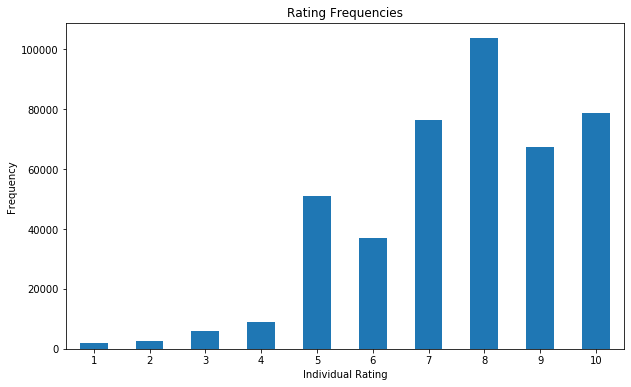

In [17]:
ax = bx_book_r["Book-Rating"].value_counts().sort_index().plot.bar(title="Rating Frequencies", figsize=(10,6), rot=0)
ax.set(xlabel="Individual Rating", ylabel="Frequency")
ax.patch.set_alpha(0.4)
ax

In [7]:
# 
bx_br = bx_book_r[["ISBN", "Book-Rating"]].groupby("ISBN").agg(["mean", "count"]).join(bx_books.set_index("ISBN")).dropna()
bx_br.columns = ["Av Rating", "Ratings Count", 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher']
bx_br

C:\Users\fergu\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


,Av Rating,Ratings Count,Book-Title,Book-Author,Year-Of-Publication,Publisher
ISBN,,,,,,
0000913154,8.0,1,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
0001046438,9.0,1,Liar,Stephen Fry,0,Harpercollins Uk
000104687X,6.0,1,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
0001047213,9.0,1,The Fighting Man,Gerald Seymour,1993,HarperCollins Publishers
0001047973,9.0,2,Brave New World,Aldous Huxley,1999,Trafalgar Square Publishing
...,...,...,...,...,...,...
B0001FZGPI,7.0,1,The Bonesetter's Daughter,Amy Tan,2001,Putnam Pub Group
B0001FZGRQ,9.0,1,The Clan of the Cave Bear,Jean M. Auel,2001,Crown Publishing Group
B0001GMSV2,8.0,2,Find Me,Rosie O'Donnell,2002,Warner Books


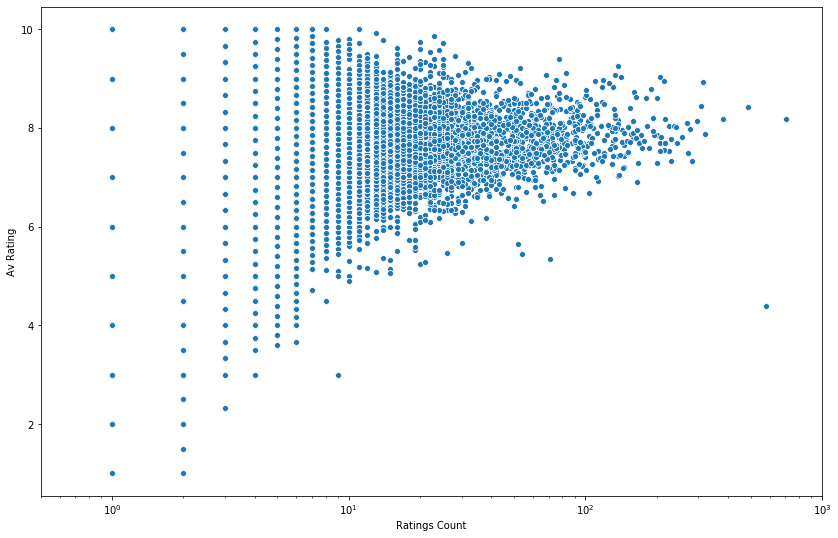

In [25]:
f, ax = plt.subplots(figsize=(14, 9))
ax.set(xscale="log", xlim=(0.5,1000))
ax.patch.set_alpha(0.4)
# ax.set_title("Ratings Count vs Average Rating")
sns.scatterplot("Ratings Count", "Av Rating", data=bx_br, ax=ax)

In [9]:
# Calculate Standard Deviation of all ratings
votstd = np.std(bx_book_r["Book-Rating"])

In [10]:
# The following are various attempts to define functions that will modify the rating scores to score higher for books with more ratings. 
bx_br["Mod rating"] = bx_br["Av Rating"] - 2*votstd/bx_br["Ratings Count"]

In [11]:
bx_br["Mod rating"] = bx_br["Av Rating"]*bx_br["Ratings Count"]**0.05

In [22]:
bx_br["Mod rating"] = ((bx_br["Av Rating"] - 2*votstd/bx_br["Ratings Count"])*bx_br["Ratings Count"]**0.02+3)*1000

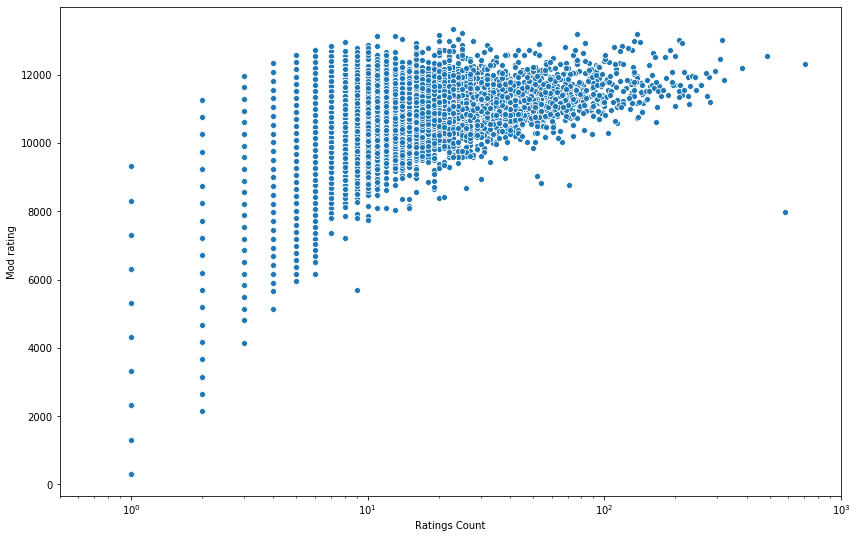

In [27]:
f, ax = plt.subplots(figsize=(14, 9))
ax.set(xscale="log", xlim=(0.5,1000))
ax.patch.set_alpha(0.4)
# ax.set_title("Ratings Count vs Modified Rating")
sns.scatterplot("Ratings Count", "Mod rating", data=bx_br, ax=ax)

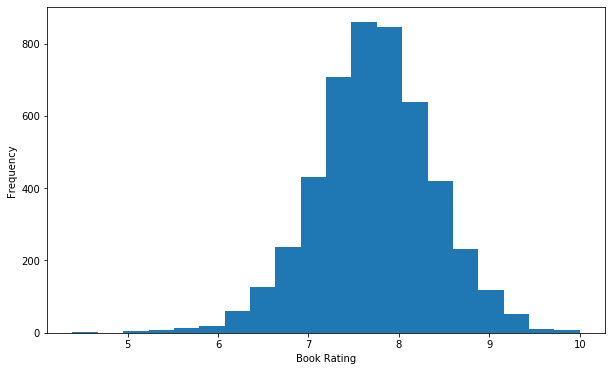

In [16]:
ax = bx_br[bx_br["Ratings Count"]>10]["Av Rating"].hist(bins=20,figsize=(10,6))
ax.set(xlabel="Book Rating", ylabel="Frequency")
ax.grid(False)
ax.patch.set_alpha(0.4)
ax

In [15]:
bx_br.nlargest(20, "Mod rating")

,Av Rating,Ratings Count,Book-Title,Book-Author,Year-Of-Publication,Publisher,Mod rating
ISBN,,,,,,,
0439425220,9.869565,23,Harry Potter and the Chamber of Secrets Postca...,J. K. Rowling,2002,Scholastic,10.337597
0618002235,9.720000,25,"The Two Towers (The Lord of the Rings, Part 2)",J. R. R. Tolkien,1999,Houghton Mifflin Company,10.209019
0345339738,9.402597,77,"The Return of the King (The Lord of the Rings,...",J.R.R. TOLKIEN,1986,Del Rey,10.203754
0439139597,9.262774,137,Harry Potter and the Goblet of Fire (Book 4),J. K. Rowling,2000,Scholastic,10.190878
0060256656,9.750000,20,The Giving Tree,Shel Silverstein,1964,HarperCollins Publishers,10.156258
0836213319,9.923077,13,Dilbert: A Book of Postcards,Scott Adams,1996,Andrews McMeel Pub,10.146812
1888054557,10.000000,11,Postmarked Yesteryear: 30 Rare Holiday Postcards,Pamela E. Apkarian-Russell,2001,Collectors Press,10.139560
0836220889,9.583333,24,Calvin and Hobbes,Bill Watterson,1987,Andrews McMeel Publishing,10.048503
0394800389,9.785714,14,Fox in Socks (I Can Read It All by Myself Begi...,Dr. Seuss,1965,Random House Children's Books,10.038414
